In [52]:
#coding:utf-8
import numpy as np
import scipy
from scipy import linalg
import cv2

%matplotlib inline
import matplotlib.pyplot as plt

In [53]:
src = cv2.cvtColor(cv2.imread('../datas/f2.jpg'),cv2.COLOR_BGR2RGB)

In [54]:
illuminants = \
    {"A": {'2': (1.098466069456375, 1, 0.3558228003436005),
           '10': (1.111420406956693, 1, 0.3519978321919493)},
     "D50": {'2': (0.9642119944211994, 1, 0.8251882845188288),
             '10': (0.9672062750333777, 1, 0.8142801513128616)},
     "D55": {'2': (0.956797052643698, 1, 0.9214805860173273),
             '10': (0.9579665682254781, 1, 0.9092525159847462)},
     "D65": {'2': (0.95047, 1., 1.08883),   # This was: `lab_ref_white`
             '10': (0.94809667673716, 1, 1.0730513595166162)},
     "D75": {'2': (0.9497220898840717, 1, 1.226393520724154),
             '10': (0.9441713925645873, 1, 1.2064272211720228)},
     "E": {'2': (1.0, 1.0, 1.0),
           '10': (1.0, 1.0, 1.0)}}

def get_xyz_coords(illuminant, observer):
    illuminant = illuminant.upper()
    try:
        return illuminants[illuminant][observer]
    except KeyError:
        raise ValueError("Unknown illuminant/observer combination\
        (\'{0}\', \'{1}\')".format(illuminant, observer))

def _prepare_colorarray(img):
    shape = img.shape
    return np.reshape(img,(shape[0] * shape[1],shape[2]))

def xyz2luv(xyz,illuminant="D65", observer="2"):
    arr = _prepare_colorarray(xyz)
    shape = xyz.shape
    # extract channels
    x, y, z = arr[..., 0], arr[..., 1], arr[..., 2]

    eps = np.finfo(np.float).eps

    # compute y_r and L
    xyz_ref_white = get_xyz_coords(illuminant, observer)
    L = y / xyz_ref_white[1]
    mask = L > 0.008856
    L[mask] = 116. * np.power(L[mask], 1. / 3.) - 16.
    L[~mask] = 903.3 * L[~mask]

    u0 = 4 * xyz_ref_white[0] / np.dot([1, 15, 3], xyz_ref_white)
    v0 = 9 * xyz_ref_white[1] / np.dot([1, 15, 3], xyz_ref_white)

    # u' and v' helper functions
    def fu(X, Y, Z):
        return (4. * X) / (X + 15. * Y + 3. * Z + eps)

    def fv(X, Y, Z):
        return (9. * Y) / (X + 15. * Y + 3. * Z + eps)

    # compute u and v using helper functions
    u = 13. * L * (fu(x, y, z) - u0)
    v = 13. * L * (fv(x, y, z) - v0)

    luv = np.concatenate([q[..., np.newaxis] for q in [L, u, v]], axis=-1)
    return np.reshape(luv,shape)

xyz_from_rgb = np.array([[0.412453, 0.357580, 0.180423],
                         [0.212671, 0.715160, 0.072169],
                         [0.019334, 0.119193, 0.950227]])

rgb_from_xyz = linalg.inv(xyz_from_rgb)

def rgb2xyz(img_rgb):
    shape = img_rgb.shape
    rgb = np.float64(img_rgb)
    arr = np.reshape(rgb,(shape[0] * shape[1],shape[2]))
    xyz = np.dot(arr,xyz_from_rgb.T.copy())
    xyz = np.reshape(xyz,shape)
    return xyz

def xyz2rgb(img_xyz):
    shape = img_xyz.shape
    xyz = np.float64(img_xyz)
    arr = np.reshape(xyz,(shape[0] * shape[1],shape[2]))
    rgb = np.dot(arr,rgb_from_xyz.T.copy())
    rgb = np.reshape(rgb,shape)
    return cv2.convertScaleAbs(rgb)

def luv2xyz(img_luv,illuminant="D65", observer="2"):
    shape = img_luv.shape
    arr = _prepare_colorarray(luv).copy()

    L, u, v = arr[..., 0], arr[..., 1], arr[..., 2]

    eps = np.finfo(np.float).eps

    # compute y
    y = L.copy()
    mask = y > 7.999625
    y[mask] = np.power((y[mask] + 16.) / 116., 3.)
    y[~mask] = y[~mask] / 903.3
    xyz_ref_white = get_xyz_coords(illuminant, observer)
    y *= xyz_ref_white[1]

    # reference white x,z
    uv_weights = [1, 15, 3]
    u0 = 4 * xyz_ref_white[0] / np.dot(uv_weights, xyz_ref_white)
    v0 = 9 * xyz_ref_white[1] / np.dot(uv_weights, xyz_ref_white)

    # compute intermediate values
    a = u0 + u / (13. * L + eps)
    b = v0 + v / (13. * L + eps)
    c = 3 * y * (5 * b - 3)

    # compute x and z
    z = ((a - 4) * c - 15 * a * b * y) / (12 * b)
    x = -(c / b + 3. * z)

    xyz = np.concatenate([q[..., np.newaxis] for q in [x, y, z]], axis=-1)
    return np.reshape(xyz,shape)

def rgb2luv(src):
    return xyz2luv(rgb2xyz(src))

def luv2rgb(src):
    return xyz2rgb(luv2xyz(src))

Text(0.5,1,'RGB->XYZ')

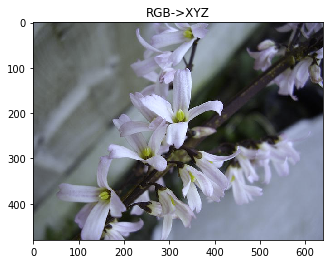

In [55]:
xyz = rgb2xyz(src)
plt.imshow(cv2.convertScaleAbs(xyz))
plt.title('RGB->XYZ')

(480, 640, 3)


Text(0.5,1,'XYZ->LUV')

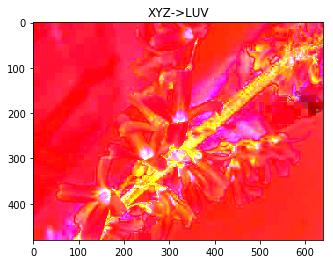

In [56]:
luv = xyz2luv(xyz)
print(luv.shape)
plt.imshow(cv2.convertScaleAbs(luv))
plt.title('XYZ->LUV')

Text(0.5,1,'LUV->XYX')

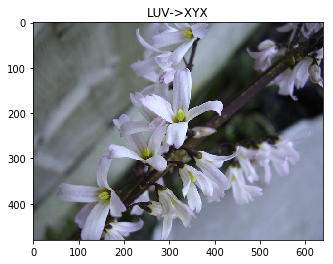

In [57]:
xyz = luv2xyz(luv)
plt.imshow(cv2.convertScaleAbs(xyz))
plt.title('LUV->XYX')

Text(0.5,1,'RGB->LUV')

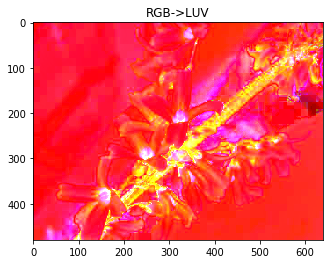

In [58]:
luv = rgb2luv(src)
plt.imshow(cv2.convertScaleAbs(luv))
plt.title('RGB->LUV')

Text(0.5,1,'LUV->RGB')

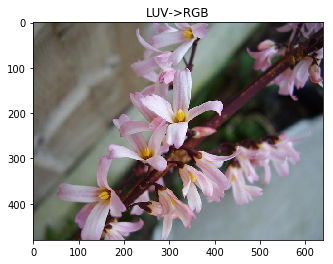

In [59]:
rgb = luv2rgb(luv)
plt.imshow(rgb)
plt.title('LUV->RGB')